# Star vs Galaxy Classification

**Author**: [Esteban Duran](https://github.com/astroesteban)

**Description**: This notebook is used to train a classification algorithm on
star vs galaxy data. The [Fast.AI](https://www.fast.ai) library is used for
data analysis and model training. The data set that is used in this notebook is
that of Star vs Galaxy image classification from Kaggle. It is a rather small
dataset with significant more galaxy images than star images. This notebook
will perform some data analysis and model training to come up with a highly
accurate neural network model.

**Dataset**: [Star-Galaxy Classification Data](https://www.kaggle.com/datasets/divyansh22/dummy-astronomy-data)

## 0. Setup

Lets start by setting up our Jupyter Notebook and importing all of the modules
we need for machine learning.

In [2]:
# Import all the modules we will need
import fastbook
from fastbook import *
from fastai.vision.all import *
from fastcore.all import *
import seaborn as sns
import torch

torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)

sns.set_theme()

# ! We need this to get some of the training output to work. This will be fixed
# in a future release of Jupyter for VS Code.
# https://github.com/microsoft/vscode-jupyter/pull/13442#issuecomment-1541584881
from IPython.display import clear_output, display, DisplayHandle, Image


def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)


DisplayHandle.update = update_patch

## 1. Download the Data

Now that we have all of our packages imported and our notebook set up, we can
proceed with downloading our data from Kaggle.

In [3]:
dataset_name = "divyansh22/dummy-astronomy-data"
dataset_path = URLs.path(dataset_name)

dataset_path

Path('/root/.fastai/archive/dummy-astronomy-data')

In [4]:
Path.BASE_PATH = dataset_path

In [5]:
# Download the dataset to a hidden folder and extract it from kaggle
if not dataset_path.exists() or not any(Path(dataset_path).iterdir()):
    import kaggle

    dataset_path.mkdir(parents=True, exist_ok=True)
    kaggle.api.dataset_download_cli(dataset_name, path=dataset_path, unzip=True)

dataset_path.ls()

(#2) [Path('star'),Path('galaxy')]

The data is inside of a "Cutout Files" folder. We want to move the files that 
are in there to be directly beneath the "dummy-astronomy-data" folder.

In [6]:
if not Path(dataset_path / "star").is_dir():
    shutil.move(Path(dataset_path / "Cutout Files" / "galaxy"), dataset_path)
    shutil.move(Path(dataset_path / "Cutout Files" / "star"), dataset_path)
    shutil.rmtree(Path(dataset_path / "Cutout Files"))

dataset_path.ls()

(#2) [Path('star'),Path('galaxy')]

In [7]:
galaxy_data_folder = dataset_path / "galaxy"
star_data_folder = dataset_path / "star"

## 2. Exploratory Data Analysis (EDA)

Now that we have our data we can begin exploring, analyzing, and visualizing
our data.

Lets start by taking a look at how many samples we have of each class (star, 
and galaxy) and how many we have in total.

<AxesSubplot: >

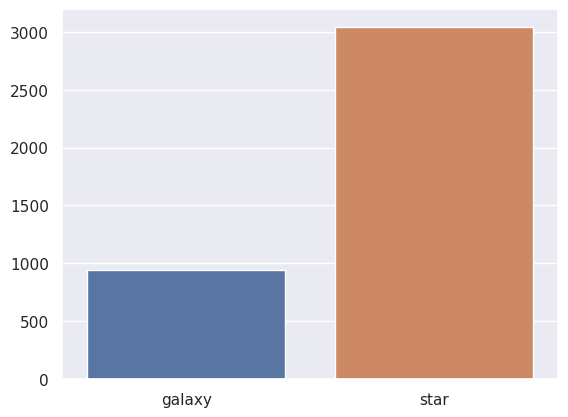

In [8]:
num_galaxy_images = sum(
    1 for file in galaxy_data_folder.iterdir() if file.suffix == ".jpg"
)
num_star_images = sum(1 for file in star_data_folder.iterdir() if file.suffix == ".jpg")

sns.barplot(x=["galaxy", "star"], y=[num_galaxy_images, num_star_images])

As we can see we have significantly more star images than we do galaxy images.
This is pretty significant imbalance in our dataset that we need to account for
to make sure our model isn't too skewed towards identifying stars.

Lets now actually take a look at an image from each of the two classes.

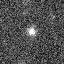

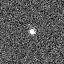

In [9]:
galaxy_img = galaxy_data_folder / Path(galaxy_data_folder.ls()[0])
star_img = star_data_folder / Path(star_data_folder.ls()[0])

display(Image(filename=galaxy_img)), display(Image(filename=star_img));

To the untrained eye these images can appear as just pixelated noise. In reality
these images contain some of the most astounding objects in our universe. A 
neural network should be able to distinguish the two after some training.

### Create a DataLoader

Now that we have our data prepared we can proceed to creating a `DataLoader`
object. This object will be used to load our data and pass it into our model
for training.

But before we do that lets actually move an image as a holdout to do a quick
test after training.

In [10]:
test_folder = Path(dataset_path / ".." / "test")

if not test_folder.exists():
    test_folder.mkdir()
    test_image = galaxy_data_folder / galaxy_data_folder.ls()[0]
    shutil.move(test_image, Path(test_folder / "galaxy.jpg"))

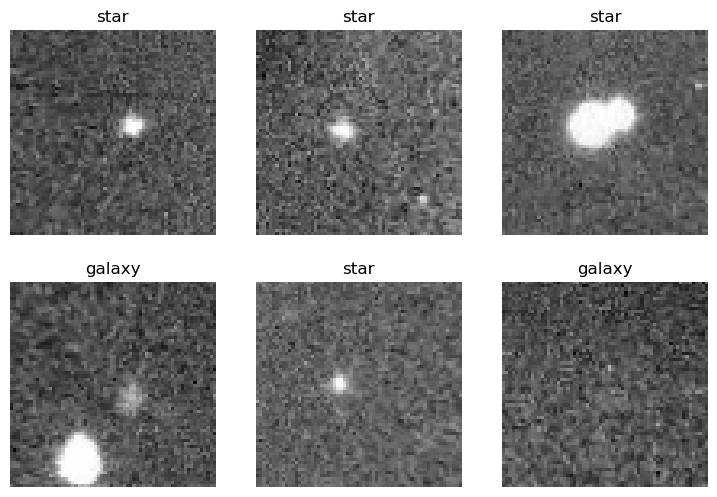

In [11]:
# With Fast.AI we can easily create a DataLoader via the Datablock
data_loader = DataBlock(
    blocks=(
        ImageBlock,
        CategoryBlock,
    ),  # the inputs to our model are images and the outputs are categories
    get_items=get_image_files,  # to find the inputs to our model run the get_image_files function
    splitter=RandomSplitter(
        valid_pct=0.2
    ),  # split the data into training and validation, 20% of which is for validation
    get_y=parent_label,
    batch_tfms=aug_transforms(
        size=64, flip_vert=True
    ),  # we also apply some image augmentations
).dataloaders(dataset_path, bs=32)

data_loader.show_batch(max_n=6)

Note that in the data loader we are also generating image augmentations. These
agumentations like horizontal flip essentially gives us more data for free to
train on. This will be crucial given the limited number of samples we have for
galaxy images.

## 3. Training

Now that we have our data loaded into a `DataLoader` and split into training and validation we can
begin training some models!

First we need to define some hyperparameters.

In [12]:
EPOCHS: int = 3

We're also gonna be training two models. A baseline _ResNet18_ and a _ConvNeXt_
model.

In [13]:
# A learner is just a wrapper around the model, data loader and metrics
resnet_learner = vision_learner(data_loader, "resnet18", metrics=accuracy)
convnext_learner = vision_learner(data_loader, "convnext_tiny.fb_in22k", metrics=accuracy)

In [14]:
resnet_learner.fine_tune(EPOCHS)

epoch,train_loss,valid_loss,accuracy,time
0,0.763895,0.506514,0.767880,00:54
1,0.664355,0.492379,0.785445,00:57
2,0.608526,0.466246,0.787955,00:57


In [15]:
convnext_learner.fine_tune(EPOCHS)

epoch,train_loss,valid_loss,accuracy,time
0,0.573735,0.393918,0.855709,02:30
1,0.497023,0.299768,0.882058,02:34
2,0.414366,0.297912,0.888331,02:35


We can see that the _ConvNeXt_ model provides a performance improvement
over the _ResNet18_. That's to be expected. The former is a much better model
than our baseline ResNet.

Lets actually see how our ConvNeXt model performed on some of these images.

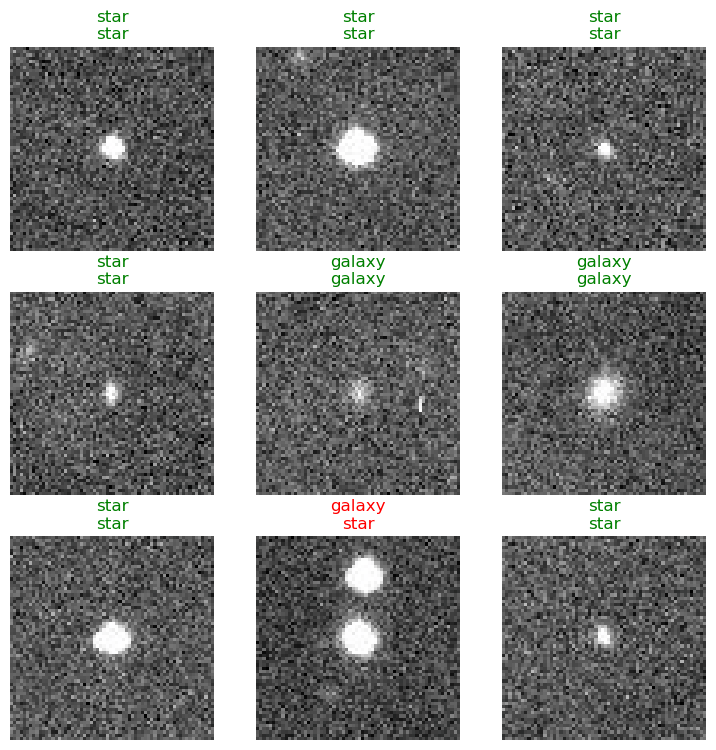

In [16]:
convnext_learner.show_results()

We can also take a look at the confusion matrix which is a handy visualization
tool to undertand the performance of our model.

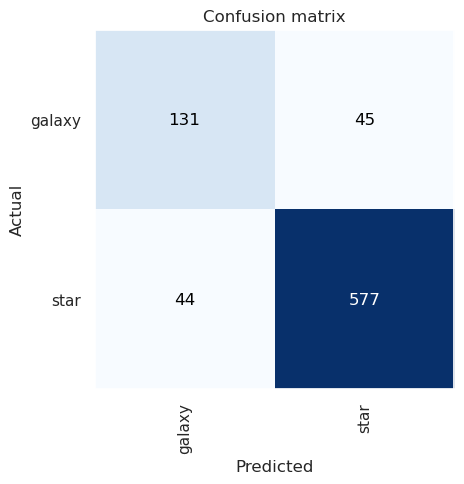

In [18]:
# Finally lets show the confusion matrix
class_interp = ClassificationInterpretation.from_learner(convnext_learner)
class_interp.plot_confusion_matrix()

We can see from the confusion matrix that the model is significantly better at
predicting stars than galaxies. This is due to the unbalanced dataset having
significantly more stars than galaxies in it.

Lets also take a look at the top losses to get a better understanding.

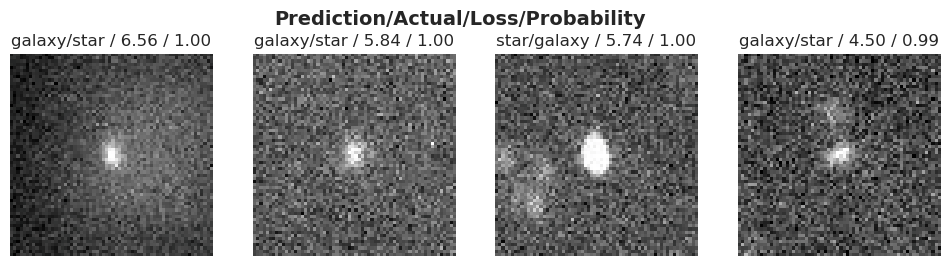

In [19]:
class_interp.plot_top_losses(4, nrows=1)

And we can also take a look at the classification report.

In [20]:
class_interp.print_classification_report()

              precision    recall  f1-score   support

      galaxy       0.75      0.74      0.75       176
        star       0.93      0.93      0.93       621

    accuracy                           0.89       797
   macro avg       0.84      0.84      0.84       797
weighted avg       0.89      0.89      0.89       797



In the classification report we can again see again that the performance is much
better in classifying stars over galaxies. The imbalances of the dataset are
showing. The `F1 Score` demonstrates an approximate 0.2 difference in performance
between the two classes.

## Improving the Model

In our first round of experiments we saw that our _ConvNeXt_ model was able to
achieve ~88% accuracy. However, the model's performance on the galaxy samples
was significantly less than the stars. This is due to the significant class
imbalance. A class imbalance can significantly degrade model performance.

In this section we will implement a couple of techniques to fix the class
imbalance to improve our model's performance.

### CrossEntropyLoss

One way that we can improve our performance is by using the [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

This loss assigns weights to the classes to help even out an unbalanced dataset.

In [27]:
# * I did a bit of experimentation and found [0.75, 0.25] to be a good weight
weight = torch.tensor((0.80, 0.20))

convnext_learner.loss_fn = nn.CrossEntropyLoss(weight=weight)

In [28]:
convnext_learner.fine_tune(EPOCHS)

epoch,train_loss,valid_loss,accuracy,time
0,0.279058,0.277570,0.880803,02:45
1,0.267582,0.279332,0.890841,02:37
2,0.252669,0.230112,0.917189,02:46


We finally got our model to 90% accuracy. I think that's pretty good given our
small imbalanced dataset.

### Test the Model

Remember that holdout galaxy image we set aside? Lets now grab it and make a
prediction on it to do a quick test of our model.

In [29]:
predictions = []

is_galaxy, _, probs = convnext_learner.predict(Path(test_folder / "galaxy.jpg"))

print(is_galaxy, probs)

galaxy TensorBase([0.7543, 0.2457])


## Conclusion

In this Jupyter notebook we trained a couple of simple and small models on a
very small dataset. The dataset contained two classes and was heavily imbalanced
towards one class. 

The overall accuracy of our model was approximately 91.7% which isn't too bad
with the small dataset of about 4,000 images.